In [1]:
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

## Import model and data

In [2]:
model = sbm.EQTransformer(phases='PS')

model.cuda();

In [3]:
data = sbd.Iquique(sampling_rate=100)
train, dev, test = data.train_dev_test()

2022-03-07 23:11:45,067 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb


## Set up and augment training data

In [4]:
# Map columns of metadata to relevant pick types:

phase_dict = {
    "trace_P_arrival_sample": "P",
    "trace_S_arrival_sample": "S",
}

In [65]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)


# Augmentations courtesy Yiyu Ni
augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen = 12000, selection = 'first', strategy="pad"),
    sbg.RandomWindow(windowlen=6000),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.DetectionLabeller("trace_P_arrival_sample", "trace_S_arrival_sample", dim = 0, key = ("X", 'y2')),
    sbg.TriangularLabeller(label_columns=phase_dict, sigma=10, dim=0, key = ("X", 'y1'))]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)

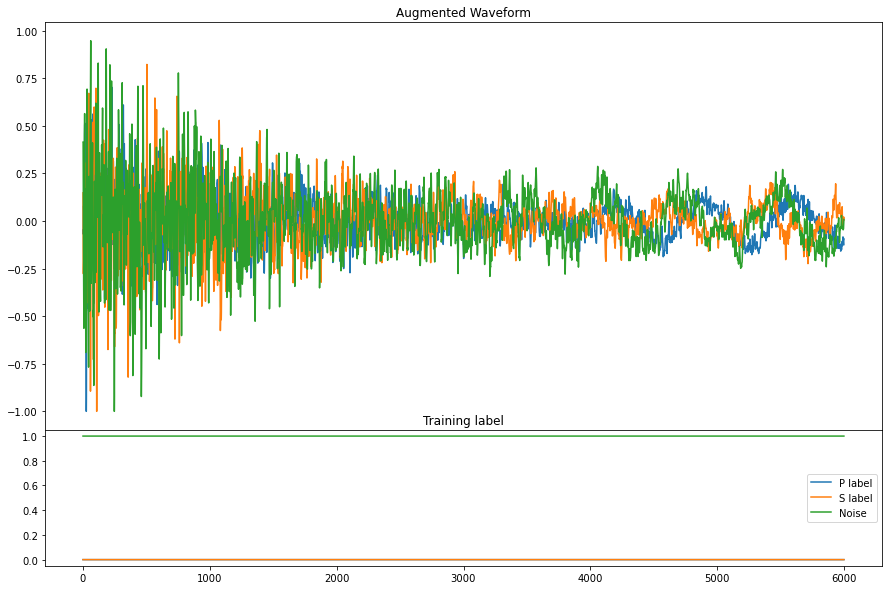

In [53]:
sample = train_generator[np.random.randint(len(train_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T)
axs[0].set_title('Augmented Waveform')
axs[1].plot(sample["y"].T)
axs[1].set_title('Training label')
axs[1].legend(['P label','S label','Noise'])

## Set up training

In [66]:
batch_size = 256
num_workers = 4  # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

In [9]:
learning_rate = 1e-2
epochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def loss_fn(y_pred, y_true, eps = 1e-5, alpha = 100):
    # Reshape
    y_pred = torch.stack(y_pred,dim=1)
    # vector cross entropy loss
    h = y_true * torch.log(y_pred + eps) # Same shape as both inputs
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h

In [67]:
def loss_fn(y_pred, y1_true, y2_true, eps = 1e-5, alpha = 100):
    # vector cross entropy loss
    p = y1_true[:, 0, :] * torch.log(y_pred[1] + eps) - 0.2 * y_pred[1]
    p = p.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    
    s = y1_true[:, 1, :] * torch.log(y_pred[2] + eps) - 0.2 *  y_pred[2]
    s = s.mean(-1).sum(-1)
    
    detection = y2_true[:, 0, :] * torch.log(y_pred[0] + eps)
    detection = detection.mean(-1).sum(-1) / alpha
    
    return -(s + p + detection)

In [68]:
# TESTING- for EQTransformer
model = sbm.EQTransformer(phases="PS")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_loop(dataloader):
    size = len(dataloader.dataset)
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(batch["X"].to(model.device))
        # loss = loss_fn(pred, batch["y"].to(model.device))
        loss = loss_fn(pred, batch["y1"].to(model.device), batch["y2"].to(model.device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(model.device))
            test_loss += loss_fn(pred, batch["y1"].to(model.device), batch["y2"].to(model.device))

.item()

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")

## Perform training

In [69]:
%%time

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader)
    test_loop(dev_loader)

Epoch 1
-------------------------------
loss: 52.584666  [    0/ 8040]
loss: 28.353595  [ 1280/ 8040]
loss: 27.817429  [ 2560/ 8040]
loss: 27.018512  [ 3840/ 8040]
loss: 26.385219  [ 5120/ 8040]
loss: 25.754288  [ 6400/ 8040]
loss: 24.933663  [ 7680/ 8040]


KeyError: 'y'

In [ ]:
sample = dev_generator[np.random.randint(len(dev_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

with torch.no_grad():
    pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)